<a href="https://colab.research.google.com/github/saltycookie/RLIntroNotebook/blob/main/Chapter_6_TD_Learning_on_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import abc
import matplotlib.pyplot as plt
import enum
from dataclasses import dataclass
import copy

In [30]:
x = np.array([[1, 2], [3, 4]])
x[0]

array([1, 2])

In [36]:
class DiscreteEnv(abc.ABC):
  def __init__(self, gamma=1.0):
    self.gamma = gamma

  @abc.abstractmethod
  def num_states(self):
    pass

  @abc.abstractmethod
  def num_actions(self):
    pass

  @abc.abstractmethod
  def init(self):
    pass

  @abc.abstractmethod
  def possible_actions(self, state):
    pass

  @abc.abstractmethod
  def step(self, action):
    pass

  @abc.abstractmethod
  def is_terminal(self):
    pass

  @abc.abstractmethod
  def init(self):
    pass

class PlayerAction(enum.Enum):
  HIT = 0
  STAND = 1


@dataclass
class BlackjackState:
  player_sum: int
  player_has_ace: bool
  dealer_first_card: int
  dealer_sum: int
  dealer_has_ace: bool
  is_terminal: bool

  def player_largest_sum(self):
    if self.player_sum <= 11 and self.player_has_ace:
      return self.player_sum + 10
    return self.player_sum

  def dealer_largest_sum(self):
    if self.dealer_sum <= 11 and self.dealer_has_ace:
      return self.dealer_sum + 10
    return self.dealer_sum

  def player_busted(self):
    return self.player_sum > 21

  def dealer_busted(self):
    return self.dealer_sum > 21

  def encode_visible_state(self):
    if self.is_terminal:
      return self.max_visible_state_code()
    return ((self.player_sum - 2) * 10 + (
        self.dealer_first_card - 1)) * 2 + int(self.player_has_ace)

  def to_visible_state(self):
    if self.is_terminal:
      return copy.copy(self)
    return BlackjackState(self.player_sum, self.player_has_ace,
                          self.dealer_first_card, None, None, False)

  @classmethod
  def max_visible_state_code(self):
    return 20 * 10 * 2

  @classmethod
  def decode_visible_state(cls, state):
    if state == cls.max_visible_state_code():
      return cls(None, None, None, None, None, True)
    player_has_ace = True if state % 2 else False
    state //= 2
    dealer_first_card = state % 10 + 1
    state //= 10
    player_sum = state + 2
    return cls(player_sum, player_has_ace, dealer_first_card, None, None, False)


class BlackjackPlayerEnv(DiscreteEnv):
  def __init__(self, gamma=1.0):
    super().__init__(gamma)
    self.state = None

  def init(self):
    player_sum = 0
    player_has_ace = False
    for _ in range(2):
      card = self.draw_card()
      if card == 1:
        player_has_ace = True
      player_sum += card
    dealer_first_card = self.draw_card()
    dealer_second_card = self.draw_card()
    self.state = BlackjackState(
        player_sum, player_has_ace, dealer_first_card,
        dealer_first_card + dealer_second_card,
        dealer_second_card == 1 or dealer_first_card == 1,
        False)
    player_is_natural = 1 if self.state.player_largest_sum() == 21 else 0
    dealer_is_natural = 1 if self.state.dealer_largest_sum() == 21 else 0
    self.state.is_terminal = player_is_natural or dealer_is_natural
    return self.state.to_visible_state(), player_is_natural - dealer_is_natural

  def is_terminal(self):
    return self.state.is_terminal

  def num_states(self):
    return BlackjackState.max_visible_state_code() + 1

  def num_actions(self):
    return 2

  def possible_actions(self, state):
    return np.array([PlayerAction.HIT.value, PlayerAction.STAND.value])

  def step(self, action):
    if action == PlayerAction.HIT:
      card = self.draw_card()
      if card == 1:
        self.state.player_has_ace = True
      self.state.player_sum += card
      if self.state.player_busted():
        self.state.is_terminal = True
        return self.state.to_visible_state(), -1
      else:
        return self.state.to_visible_state(), 0
    if action == PlayerAction.STAND:
      self.state.is_terminal = True
      while self.state.dealer_largest_sum() < 17:
        card = self.draw_card()
        if card == 1:
          self.state.dealer_has_ace = True
        self.state.dealer_sum += card
      if self.state.dealer_busted() or (
          self.state.player_largest_sum() > self.state.dealer_largest_sum()):
        return self.state.to_visible_state(), 1
      elif self.state.player_largest_sum() == self.state.dealer_largest_sum():
        return self.state.to_visible_state(), 0
      else:
        return self.state.to_visible_state(), -1

  def draw_card(self):
    num = np.random.randint(1, 13)
    if num >= 10:
      return 10
    else:
      return num


In [56]:
@dataclass
class Step:
  state: BlackjackState
  action: int
  reward: int


class SarsaAgent:
  def __init__(self, env: BlackjackPlayerEnv, epsilon=0.01, init_q_value=0.0):
    self.env = env
    self.epsilon = epsilon
    self.q_values = np.zeros(
        (env.num_states(), env.num_actions())) + init_q_value
    self.n = np.zeros((env.num_states(), env.num_actions()), dtype=int)

  def act(self, state: BlackjackState):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.env.possible_actions(state))
    return np.argmax(self.q_values[state.encode_visible_state()])

  def update(self, prev_step: Step, next_step: Step):
    s1, a1, reward = (
        prev_step.state.encode_visible_state(),
        prev_step.action,
        prev_step.reward)
    s2, a2 = next_step.state.encode_visible_state(), next_step.action
    self.n[s1, a1] += 1
    self.q_values[s1, a1] += (
        reward + self.q_values[s2, a2] - self.q_values[s1, a1]) / self.n[s1, a1]


class ExpectedSarsaAgent:
  def __init__(self, env: BlackjackPlayerEnv, epsilon=0.01, init_q_value=0.0):
    self.env = env
    self.epsilon = epsilon
    self.q_values = np.zeros(
        (env.num_states(), env.num_actions())) + init_q_value
    self.n = np.zeros((env.num_states(), env.num_actions()), dtype=int)

  def act(self, state: BlackjackState):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.env.possible_actions(state))
    return np.argmax(self.q_values[state.encode_visible_state()])

  def update(self, prev_step: Step, next_step: Step):
    s1, a1, reward = (
        prev_step.state.encode_visible_state(),
        prev_step.action,
        prev_step.reward)
    expected_v = 0
    if not next_step.state.is_terminal:
      next_state = next_step.state.encode_visible_state()
      possible_actions = self.env.possible_actions(next_state)
      action_probs = np.zeros(self.env.num_actions())
      action_probs[possible_actions] = self.epsilon / possible_actions.size
      action_probs[np.argmax(self.q_values[next_state])] += 1 - self.epsilon
      expected_v = np.dot(self.q_values[next_state], action_probs)
    self.n[s1, a1] += 1
    self.q_values[s1, a1] += (
        reward + expected_v - self.q_values[s1, a1]) / self.n[s1, a1]


class QLearningAgent:
  def __init__(self, env: BlackjackPlayerEnv, epsilon=0.01, init_q_value=0.0):
    self.env = env
    self.epsilon = epsilon
    self.q_values = np.zeros(
        (env.num_states(), env.num_actions())) + init_q_value
    self.n = np.zeros((env.num_states(), env.num_actions()), dtype=int)

  def act_off_policy(self, state: BlackjackState):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.env.possible_actions(state))
    return self.act_on_policy(state)

  def act_on_policy(self, state: BlackjackState):
    return np.argmax(self.q_values[state.encode_visible_state()])

  def update(self, prev_step: Step, next_step: Step):
    s1, a1, reward = (
        prev_step.state.encode_visible_state(),
        prev_step.action,
        prev_step.reward)
    v = 0
    if not next_step.state.is_terminal:
      next_state = next_step.state.encode_visible_state()
      v = np.max(self.q_values[next_state])
    self.n[s1, a1] += 1
    self.q_values[s1, a1] += (
        reward + v - self.q_values[s1, a1]) / self.n[s1, a1]

In [53]:
env = BlackjackPlayerEnv()
sarsa_agent = SarsaAgent(env, epsilon=0.05)
reward_sum = 0.0
avg_rewards = []
for it in range(100000):
  state, reward = env.init()
  prev_step = None
  while not prev_step or not prev_step.state.is_terminal:
    next_step = Step(state, 0, 0)
    if not state.is_terminal:
      next_step.action = sarsa_agent.act(next_step.state)
      state, next_step.reward = env.step(PlayerAction(next_step.action))
    if prev_step:
      sarsa_agent.update(prev_step, next_step)
    prev_step = next_step
  reward_sum += reward
  avg_rewards.append(reward_sum / (it + 1))

reward_sum = 0.0
for it in range(1000):
  state, reward = env.init()
  while not state.is_terminal:
    action = sarsa_agent.act(state)
    new_state, reward = env.step(PlayerAction(action))
    state = new_state
  reward_sum += reward
reward_sum / 1000

-0.089

In [50]:
np.mean(sarsa_agent.n), np.std(sarsa_agent.n), np.count_nonzero(sarsa_agent.n > 10)

(np.float64(199.66708229426433), np.float64(358.50033321661596), 448)

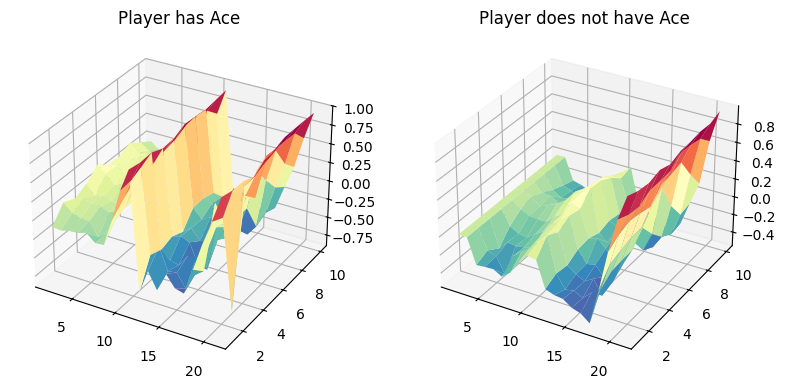

In [54]:
x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))

Z = np.max(sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player has Ace')

Z = np.max(sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player does not have Ace')

plt.show()

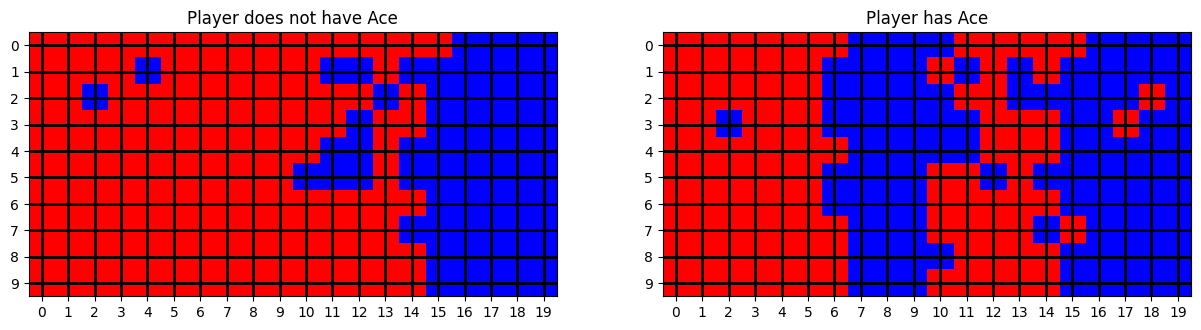

In [55]:
from matplotlib import colors

x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-1, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15, 30))

Z = np.argmax(sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player does not have Ace')

Z = np.argmax(
    sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player has Ace')

plt.show()

In [42]:
env = BlackjackPlayerEnv()
expected_sarsa_agent = ExpectedSarsaAgent(env, epsilon=0.05)
reward_sum = 0.0
avg_rewards = []
for it in range(100000):
  state, reward = env.init()
  prev_step = None
  while not prev_step or not prev_step.state.is_terminal:
    next_step = Step(state, 0, 0)
    if not state.is_terminal:
      next_step.action = expected_sarsa_agent.act(next_step.state)
      state, next_step.reward = env.step(PlayerAction(next_step.action))
    if prev_step:
      expected_sarsa_agent.update(prev_step, next_step)
    prev_step = next_step
  reward_sum += reward
  avg_rewards.append(reward_sum / (it + 1))

reward_sum = 0.0
for it in range(1000):
  state, reward = env.init()
  while not state.is_terminal:
    action = expected_sarsa_agent.act(state)
    new_state, reward = env.step(PlayerAction(action))
    state = new_state
  reward_sum += reward
reward_sum / 1000

-0.119

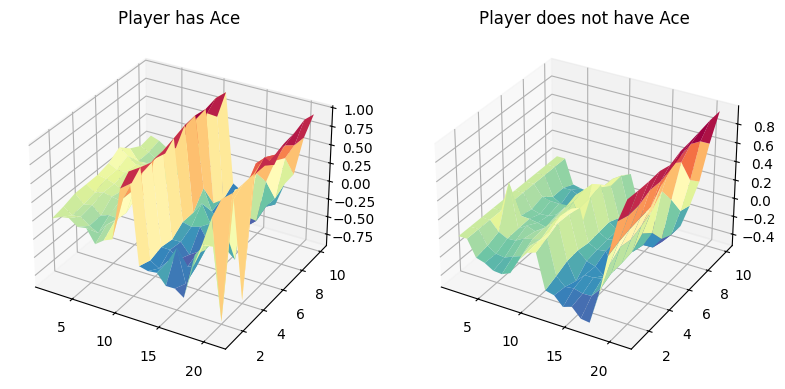

In [43]:
x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))

Z = np.max(
    expected_sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player has Ace')

Z = np.max(expected_sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player does not have Ace')

plt.show()

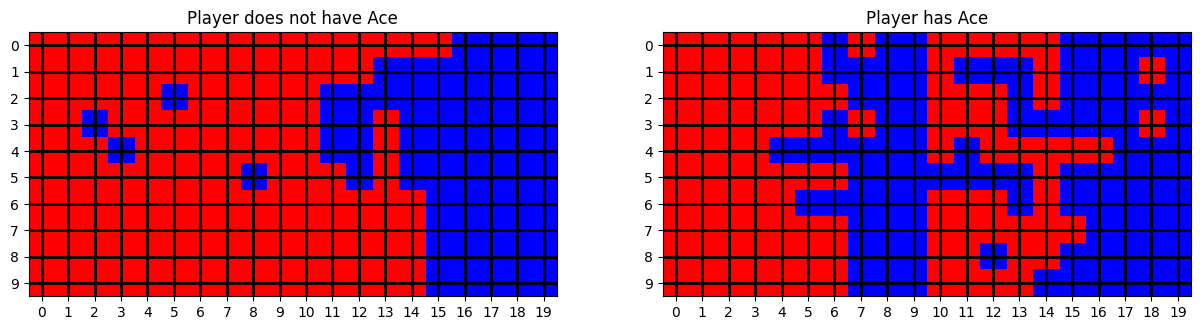

In [44]:
from matplotlib import colors

x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-1, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15, 30))

Z = np.argmax(
    expected_sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player does not have Ace')

Z = np.argmax(
    expected_sarsa_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player has Ace')

plt.show()

In [62]:
env = BlackjackPlayerEnv()
qlearning_agent = QLearningAgent(env, epsilon=0.2)
reward_sum = 0.0
avg_rewards = []
for it in range(100000):
  state, reward = env.init()
  prev_step = None
  while not prev_step or not prev_step.state.is_terminal:
    next_step = Step(state, 0, 0)
    if not state.is_terminal:
      next_step.action = qlearning_agent.act_off_policy(next_step.state)
      state, next_step.reward = env.step(PlayerAction(next_step.action))
    if prev_step:
      qlearning_agent.update(prev_step, next_step)
    prev_step = next_step
  reward_sum += reward
  avg_rewards.append(reward_sum / (it + 1))

reward_sum = 0.0
for it in range(1000):
  state, reward = env.init()
  while not state.is_terminal:
    action = qlearning_agent.act_on_policy(state)
    new_state, reward = env.step(PlayerAction(action))
    state = new_state
  reward_sum += reward
reward_sum / 1000

-0.039

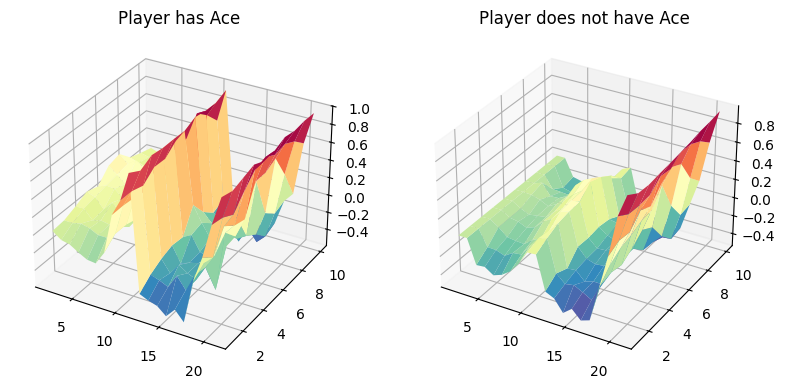

In [64]:
x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))

Z = np.max(
    qlearning_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player has Ace')

Z = np.max(qlearning_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player does not have Ace')

plt.show()

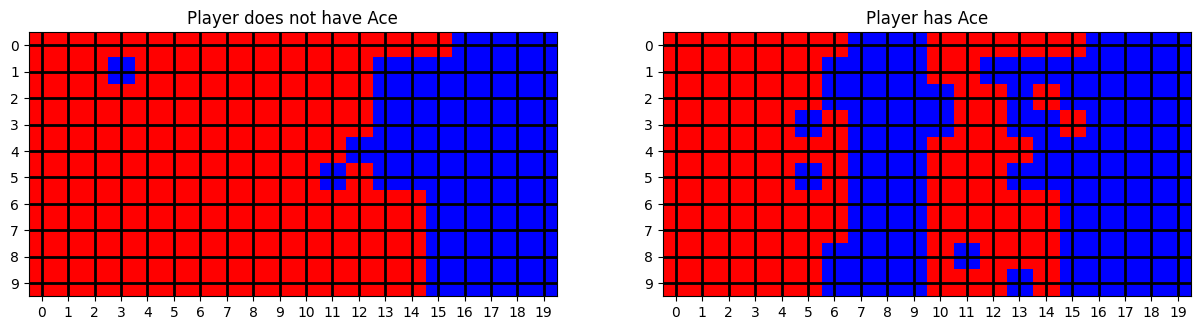

In [65]:
from matplotlib import colors

x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-1, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15, 30))

Z = np.argmax(
    qlearning_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player does not have Ace')

Z = np.argmax(
    qlearning_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player has Ace')

plt.show()